# Simulation Comparison

This notebook aims to compare the forward simulations of TEPHRA2 and GSM, as well as test the GSM inversion on both forward models. 


Currently depends on tephra2utils. This is my own package in development, but will soon be published on pip. 

In [1]:
%matplotlib notebook

from shapely.geometry import Point
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from scipy.stats import beta
from scipy.sparse.linalg import lsqr
from scipy.optimize import nnls
import matplotlib.patheffects as PathEffects
from matplotlib import cm, colors
from tephra2utils import io, vis


### Importing TEPHRA2 data

In [2]:
wind = "med"
phi = "mid"

wind_dict = {
    "no":0.001,
    "med":10,
    "hi":20
}

filename = 'wind_phi_trial/' + phi + '_phi_' + wind + '_wind.txt'
t2_df, _, _, _ = io.read_tephra2(filename)
# display(t2_df)

#savefile tag
tag = 'pr69/' + phi + '_phi_' + wind + '_wind'

#infile tag
in_tag = 'wind_phi_trial/' + phi + '_phi_' + wind + '_wind'


## Setting Eruption Parameters

In [3]:
VENT_EASTING = 0
VENT_NORTHING = 0
VENT_ELEVATION = 1
PLUME_HEIGHT = 30000
ALPHA = 3
BETA = 2
ERUPTION_MASS = 1e10
MAX_GRAINSIZE = 0.5
MIN_GRAINSIZE = 1.5
MEDIAN_GRAINSIZE = 1
STD_GRAINSIZE = 1
EDDY_CONST = 0.04
DIFFUSION_COEFFICIENT = 1000
FALL_TIME_THRESHOLD = 3600
LITHIC_DENSITY = 2700.0
PUMICE_DENSITY = 1024.0
COL_STEPS = 100
PART_STEPS = 1
PLUME_MODEL = 2

u = wind_dict[wind]
print(u)

LITHIC_DIAMETER_THRESHOLD = 7
PUMICE_DIAMETER_THRESHOLD = -1


AIR_VISCOSITY = 0.000018325
AIR_DENSITY = 1.293
GRAVITY = 9.81

if MAX_GRAINSIZE > LITHIC_DIAMETER_THRESHOLD:
    particle_density = LITHIC_DENSITY
elif MAX_GRAINSIZE < PUMICE_DIAMETER_THRESHOLD:
    particle_density = PUMICE_DENSITY
else:
    particle_density = LITHIC_DENSITY - (LITHIC_DENSITY - PUMICE_DENSITY) * (MAX_GRAINSIZE - LITHIC_DIAMETER_THRESHOLD)/(PUMICE_DIAMETER_THRESHOLD - LITHIC_DIAMETER_THRESHOLD)

print(particle_density)

10
1338.25


## The Gaussian Stack Model

Many function taken directly from TEPHRA2. 

Possible remaining differences include *sigma_squared*, and the way wind is calculated (called *statified average* in TEPHRA2. 

In [4]:
def d2phi(d):
    return - np.log2(d)

def phi2d(phi):
    return 2**(-phi)

def column_spread_fine(height):
    return (0.2*(height**2))**(2/5)
def column_spread_coarse(height):
    return 0.0032 * (height**2) / DIFFUSION_COEFFICIENT

def fall_time(terminal_velocity, release_height):
    return release_height/terminal_velocity

def func2(x, y, sigma_sqr, x_bar, y_bar):
    return 1/(2*np.pi*sigma_sqr) * np.exp(-((x - x_bar)**2 + (y - y_bar)**2)/(2*sigma_sqr))

def func(x, y, sigma_sqr, x_bar, y_bar):
    return 1/(np.pi*sigma_sqr) * np.exp(-((x - x_bar)**2 + (y - y_bar)**2)/(sigma_sqr))

def sigma_squared(height, fall_time, diff_coef, eddy_const, fall_time_thres):
    
    if fall_time < fall_time_thres:
        spread = column_spread_coarse(height)
        ss = 4*diff_coef*(fall_time + spread)
    else:
        spread = column_spread_fine(height)
        ss = ((8*eddy_const)/5) * ((fall_time + spread)**(5/2))
    if ss <=0:
        ss += 1e-9
    return ss

def landing_point(x1, z1, ux, vt):
    m = vt/ux
    return x1 - (z1/m)

def mass_dist_in_plume(dist, z_min, z_max, z_points, total_mass):
    z_norm = z_points/(z_max - z_min)
    pdf = dist.pdf(z_norm)
    pdf_sum = sum(dist.pdf(z_norm))
    norm_dist = dist.pdf(z_norm)/pdf_sum
    mass_dist = norm_dist * total_mass
    return mass_dist

def gaussian_stack_forward(p, z_min, z_max, q_dist, tot_mass, u, phi):
    # Release points in column
    layer_thickness = (z_max/p)
    z = np.linspace(z_min + layer_thickness, z_max, p)
    
    d = phi2d(phi)/1000
    vv = [-part_fall_time(zk, layer_thickness, d, particle_density)[1] for zk in z]
    ft = [part_fall_time(zk, layer_thickness, d, particle_density)[0] for zk in z]
    # Landing points of release point centers
    x_bar = [landing_point(0, zk, u, v) for zk, v in zip(z, vv)]

    #Mass distribution in the plume
    q_mass = mass_dist_in_plume(q_dist, z_min, z_max, z, tot_mass)
    
    q = q_mass
    
    input_data = np.asarray([z, np.asarray(q_mass), np.asarray(q), np.asarray(x_bar)]).T
    input_table = pd.DataFrame(input_data,  columns=["Release Height (z)", 
                                                     "Suspended Mass (q)", 
                                                     "Scaled Mass (q)", 
                                                     "Landing Points (x_bar)"])
    
    xx = np.linspace(-200000, 300000, 501)
    x_range = xx[-1] - xx[0]
    yy = np.linspace(-250000, 250000, 501)
    X, Y = np.meshgrid(xx, yy)
    dep_mass = np.zeros(X.shape)
    sus_mass = []
    sig = []

    for k, zh in enumerate(z):
        # Gaussian dispersal
        s_sqr = sigma_squared(zh, sum(ft[:k+1]), DIFFUSION_COEFFICIENT, EDDY_CONST, FALL_TIME_THRESHOLD)
        dist = strat_average(0, u, X, Y, sum(ft[:k+1]), s_sqr)
        
        dep_mass += (q[k]/(s_sqr*np.pi))*dist
        sig.append(s_sqr)
    dep_df = construct_dataframe(dep_mass, xx, yy)   
    return input_table, dep_df, sig, vv, ft

def construct_dataframe(deposit, easting, northing):
    df = pd.DataFrame(deposit.T, columns=northing, index=easting)
    df.reset_index(inplace=True)
    #display(df)
    df = pd.melt(df, id_vars=["index"])
    df = df.rename(columns={"index": "Easting", "variable": "Northing", "value":"MassArea"})
    return df

def random_sample(n, df, sample_dev, K):
    transect = df[df["Northing"]==0].values
    max_point = np.argmax(transect)
    samp_x = df["Easting"].values
    return samp_x, samp_y

def gaussian_stack_inversion(samp_df, n, p, z_min, z_max, tot_mass, u, phi, solver=None):
    # Release points in column

    layer_thickness = (z_max/p)
    z = np.linspace(z_min + layer_thickness, z_max, p)

    d = phi2d(phi)/1000
    vv = [-part_fall_time(zk, layer_thickness, d, particle_density)[1] for zk in z]
    ft = [part_fall_time(zk, layer_thickness, d, particle_density)[0] for zk in z]
    
    # Landing points of release point centers
    x_bar = [landing_point(0, zk, u, vv[i]) for i, zk in enumerate(z)]
    
    samp_x = samp_df['Easting'].values
    samp_y = samp_df["Northing"].values
    m = samp_df["MassArea"].values

    A = np.zeros((n,p))
    for i in range(n):
        for k in range(p):
            s_sqr = sigma_squared(z[k], sum(ft[:k+1]), 
                                  DIFFUSION_COEFFICIENT, 
                                  EDDY_CONST, 
                                  FALL_TIME_THRESHOLD)
            dist = strat_average(0, u, samp_x[i], samp_y[i], sum(ft[:k+1]), s_sqr)
            A[i,k] = (1/(s_sqr*np.pi))*dist
    coefficient_matrix = pd.DataFrame(A)
    if n == p:
        det = np.linalg.det(A)
    else: 
        det = None
    rank = np.linalg.matrix_rank(A)
    
    if solver=='lsqr':
        lst_q = lsqr(A, m, damp=1e-10)
        q_inv = np.asarray(lst_q[0])
        q_inv_mass = q_inv
        print(lst_q)
    elif solver=='jacobi':
        P = np.diag(np.diag(A))
        P_inv = np.linalg.inv(P)
        cond_A = np.matmul(A, P_inv)
        y_sol = np.linalg.solve(cond_A, m)
        q_inv = np.linalg.solve(P, y_sol)
        q_inv_mass = q_inv
    else:
        q_inv = np.linalg.lstsq(A, m)
        q_inv_mass = q_inv[0]
    
    inversion_data = np.asarray([np.asarray(z), q_inv_mass]).T
    inversion_table = pd.DataFrame(inversion_data, columns=["Height", "Suspended Mass"])
    return inversion_table, coefficient_matrix, det, rank

def part_fall_time(particle_ht, layer, ashdiam, part_density):
    hz = particle_ht # height of particle above sea level
    particle_fall_time = 0.0
    
    # rho is the density of air (kg/m^3) at the elevation of the current particle
    rho = AIR_DENSITY * np.exp(-hz/8200.0) 
    
    #  (friction due to the air) :
    #  vtl is terminal velocity (m/s) in laminar regime RE<6
    #  vti is terminal velocity (m/s) in intermediate regime 6<RE<500
    #  vtt is terminal velocity (m/s) in turbulent regime RE>500
    
    vtl = part_density * GRAVITY * ashdiam * ashdiam / (AIR_VISCOSITY * 18.0)
    
    reynolds_number = ashdiam * rho * vtl / AIR_VISCOSITY
    particle_term_vel = vtl
    temp0 = ashdiam * rho
    
    if reynolds_number >= 6.0:
        temp1 = 4.0 * GRAVITY * GRAVITY * part_density * part_density / (AIR_VISCOSITY * 225.0 * rho)
        vti = ashdiam * (temp1 ** (1./3.)) 
        reynolds_number = temp0 * vti / AIR_VISCOSITY
        particle_term_vel = vti

    # c...if intermediate RE>500 (turbulent regime), RE is calculated again considering vtt

    if reynolds_number >= 500.0:
        vtt = np.sqrt( 3.1 * part_density * GRAVITY * ashdiam / rho)
        reynolds_number =  temp0 * vtt / AIR_VISCOSITY
        particle_term_vel = vtt
    
    particle_fall_time = layer / particle_term_vel

    return (particle_fall_time, particle_term_vel)

def strat_average(average_wind_direction, average_windspeed, xspace, yspace, total_fall_time, sigma):
    temp0 = np.cos(average_wind_direction)
    temp1 = np.sin(average_wind_direction)

    xprime = xspace * temp0 + yspace * temp1
    yprime = yspace * temp0 - xspace * temp1

    temp0 = xprime - average_windspeed * total_fall_time
    demon1 = temp0 * temp0 + yprime * yprime
    demon3 = np.exp(-demon1/sigma) # where sigma is calculated for the total fall time 
    
    return demon3

### Forward Simulation

<IPython.core.display.Javascript object>


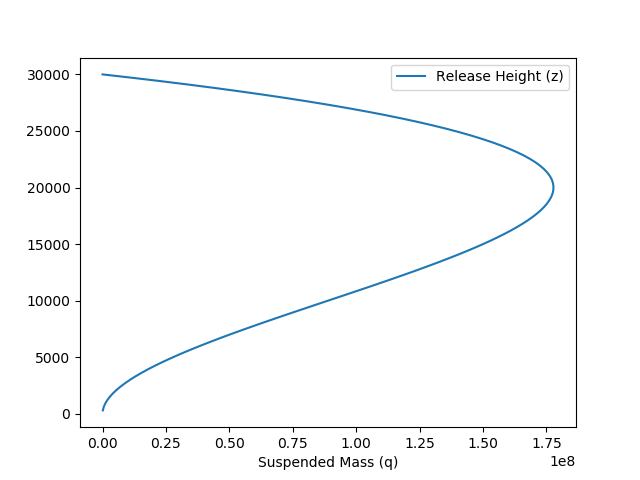

<IPython.core.display.Javascript object>


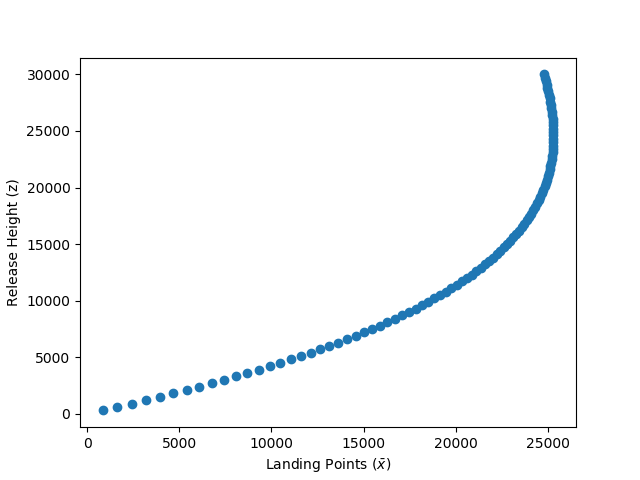

In [5]:
q_dist = beta(ALPHA,BETA)

# input_table, gsm_df, sus_mass, sig, vv, tft= gaussian_stack_forward(COL_STEPS, 0, PLUME_HEIGHT, 
#                                                          q_dist,
#                                                          ERUPTION_MASS, u, MAX_GRAINSIZE)

input_table, gsm_df, sig, vv, tft= gaussian_stack_forward(COL_STEPS, 0, PLUME_HEIGHT, 
                                                         q_dist,
                                                         ERUPTION_MASS, u, MAX_GRAINSIZE)

input_table.plot("Suspended Mass (q)", "Release Height (z)")
plt.show()


plt.figure()
plt.scatter(input_table["Landing Points (x_bar)"], input_table["Release Height (z)"])
plt.xlabel(r"Landing Points $(\bar{x})$")
plt.ylabel(r"Release Height (z)")
plt.show()



total_P ~ 1?

correction/normalisation constant
```
total_P = (total_P_col * total_P_part);
T[i][j].demon1 = (erupt->total_ash_mass * col_prob  * part_prob)/total_P;
demon2 =  pi * sigma;
demon3 = strat_average( average_wind_direction,
                       average_windspeed,
			                 new_xspace, new_yspace,
			                 total_fall_time,
			                 sigma);
ash_fall = (T[i][j].demon1 / demon2) * demon3;
```

 


,x,j,average_windspeed,ash_fall,sigma,demon3,total_fall_time
0,-200000,0,10,0.000000e+00,332653.0,0.000000e+00,82.8754
1,-200000,1,10,0.000000e+00,663593.0,0.000000e+00,164.7460
2,-200000,2,10,0.000000e+00,992867.0,0.000000e+00,245.6250
3,-200000,3,10,0.000000e+00,1320520.0,0.000000e+00,325.5230
4,-200000,4,10,0.000000e+00,1646610.0,0.000000e+00,404.4530
5,-200000,5,10,0.000000e+00,1971170.0,0.000000e+00,482.4260
6,-200000,6,10,0.000000e+00,2294260.0,0.000000e+00,559.4540
7,-200000,7,10,0.000000e+00,2615920.0,0.000000e+00,635.5480
8,-200000,8,10,0.000000e+00,2936190.0,0.000000e+00,710.7210
9,-200000,9,10,0.000000e+00,3255120.0,0.000000e+00,784.9820


<IPython.core.display.Javascript object>


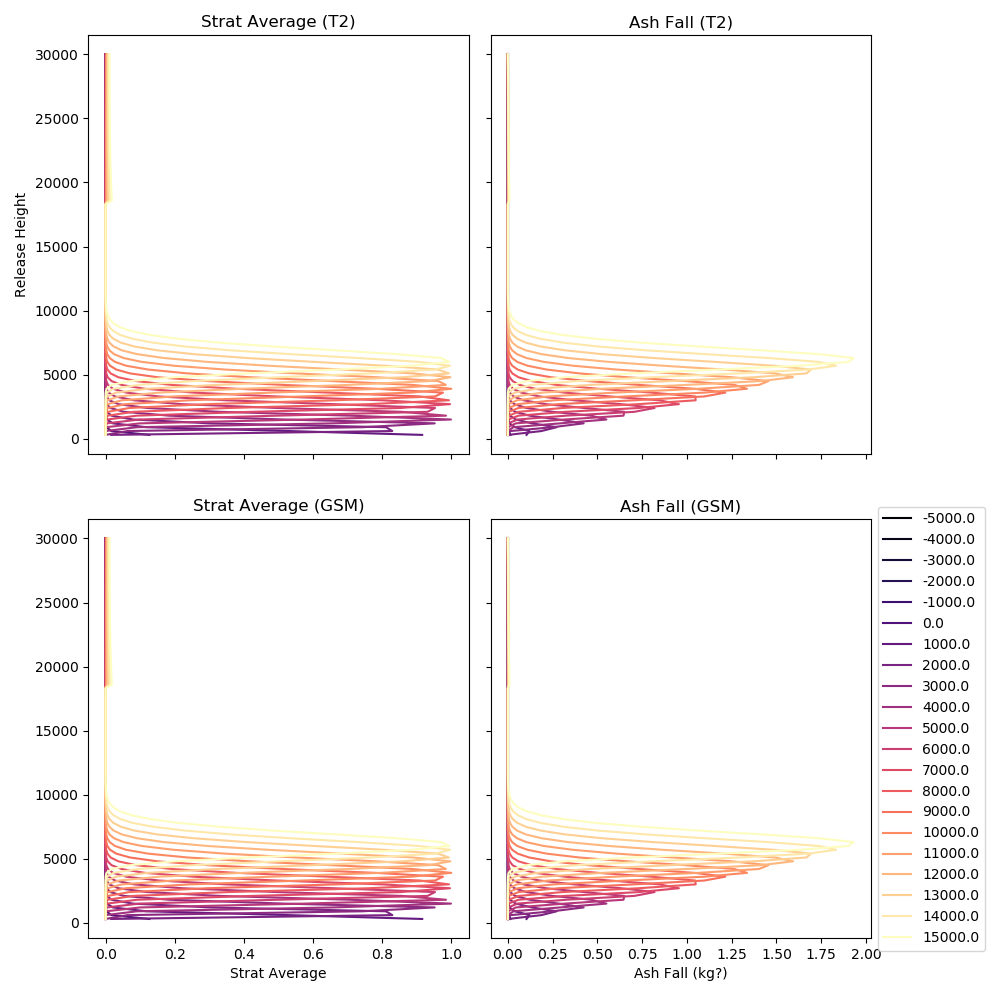

In [6]:
mass_data = pd.read_csv(in_tag + "_mass_data.csv")
display(mass_data)

x_pts = np.linspace(-5000, 15000, 21)
cmap = cm.get_cmap('magma')
norm = colors.Normalize(vmin=min(x_pts), vmax=max(x_pts))



fig, axs = plt.subplots(2,2, figsize=(
        10, 10), facecolor='w', edgecolor='k', sharey='row', sharex="col")
ax1, ax2, ax3, ax4 = axs.ravel()

for x in x_pts:
    data_sub = mass_data[mass_data['x'] == x].copy()
    data_sub["col_heights"] = input_table["Release Height (z)"].values
    if len(data_sub) > 0:
        data_sub.plot(' demon3', "col_heights", ax=ax1, c=cmap(norm(x)), legend=False)
ax1.set_title("Strat Average (T2)")
ax1.set_ylabel("Release Height")
ax1.set_xlabel("Strat Average")


for x in x_pts:
    data_sub = mass_data[mass_data['x'] == x].copy()
    data_sub["col_heights"] = input_table["Release Height (z)"].values
    if len(data_sub) > 0:
        data_sub.plot(' ash_fall', "col_heights", ax=ax2, c=cmap(norm(x)), legend=False)
ax2.set_title("Ash Fall (T2)")
ax2.set_ylabel("Release Height")
ax2.set_xlabel("Ash Fall (kg?)")

for x in x_pts:
    strat = []
    for k, zh in enumerate(input_table["Release Height (z)"].values):
        strat.append(strat_average(0, u, x, 0, sum(tft[:k+1]), sig[k]))
    ax3.plot(strat, input_table["Release Height (z)"].values, c=cmap(norm(x)))
ax3.set_title("Strat Average (GSM)")
ax3.set_xlabel("Strat Average")

for x in x_pts:
    strat = []
    for k, zh in enumerate(input_table["Release Height (z)"].values):
        strat.append(strat_average(0, u, x, 0, sum(tft[:k+1]), sig[k]))
    ash = []
    for st, q, sg in zip(strat, input_table["Suspended Mass (q)"].values, sig):
        ash.append((q/(sg*np.pi))*st)
    ax4.plot(ash, input_table["Release Height (z)"].values, c=cmap(norm(x)), label=x)
ax4.set_title("Ash Fall (GSM)")
ax4.set_xlabel("Ash Fall (kg?)")




plt.legend(loc='center left', bbox_to_anchor=(1, 0.5), ncol=1)
plt.tight_layout()
# plt.show()
plt.savefig(tag + "_strats.png", dpi=200, format='png')


In [7]:
pt_dat = mass_data[mass_data["x"] == 0]
display(pt_dat[" sigma"].values)


array([3.32653e+05, 6.63593e+05, 9.92867e+05, 1.32052e+06, 1.64661e+06,
       1.97117e+06, 2.29426e+06, 2.61592e+06, 2.93619e+06, 3.25512e+06,
       3.57275e+06, 3.88913e+06, 4.20430e+06, 4.51831e+06, 4.83119e+06,
       5.14298e+06, 5.45374e+06, 5.76349e+06, 6.07228e+06, 6.38014e+06,
       6.68713e+06, 6.99327e+06, 7.29860e+06, 7.60316e+06, 7.90700e+06,
       8.21013e+06, 8.51261e+06, 8.81447e+06, 9.11574e+06, 9.41646e+06,
       9.71666e+06, 1.00164e+07, 1.03156e+07, 1.06145e+07, 1.09130e+07,
       1.12111e+07, 1.15089e+07, 1.18064e+07, 1.21037e+07, 1.24007e+07,
       1.26975e+07, 1.29942e+07, 1.32908e+07, 1.35872e+07, 1.38836e+07,
       1.41799e+07, 1.44762e+07, 1.47725e+07, 1.50689e+07, 1.53653e+07,
       1.56618e+07, 1.59584e+07, 1.62552e+07, 1.65522e+07, 1.68493e+07,
       1.71467e+07, 1.74443e+07, 1.77422e+07, 1.80404e+07, 1.83389e+07,
       1.86378e+07, 1.12856e+08, 1.16076e+08, 1.19320e+08, 1.22587e+08,
       1.25876e+08, 1.29186e+08, 1.32517e+08, 1.35867e+08, 1.392

### Internal data comparison

Data taken from internal TEPHRA2 workings. 

My method for getting Sigma is currently broken. 

,particle_ht,layer,ashdiam,part_density,particle_term_vel,particle_fall_time
0,300.99,299.99,0.000707,1338.25,3.61977,82.8754
1,600.98,299.99,0.000707,1338.25,3.66418,81.8709
2,900.97,299.99,0.000707,1338.25,3.70914,80.8785
3,1200.96,299.99,0.000707,1338.25,3.75465,79.8982
4,1500.95,299.99,0.000707,1338.25,3.80072,78.9298
5,1800.94,299.99,0.000707,1338.25,3.84735,77.9731
6,2100.93,299.99,0.000707,1338.25,3.89455,77.0281
7,2400.92,299.99,0.000707,1338.25,3.94234,76.0944
8,2700.91,299.99,0.000707,1338.25,3.99071,75.1721
9,3000.90,299.99,0.000707,1338.25,4.03967,74.2610


<IPython.core.display.Javascript object>


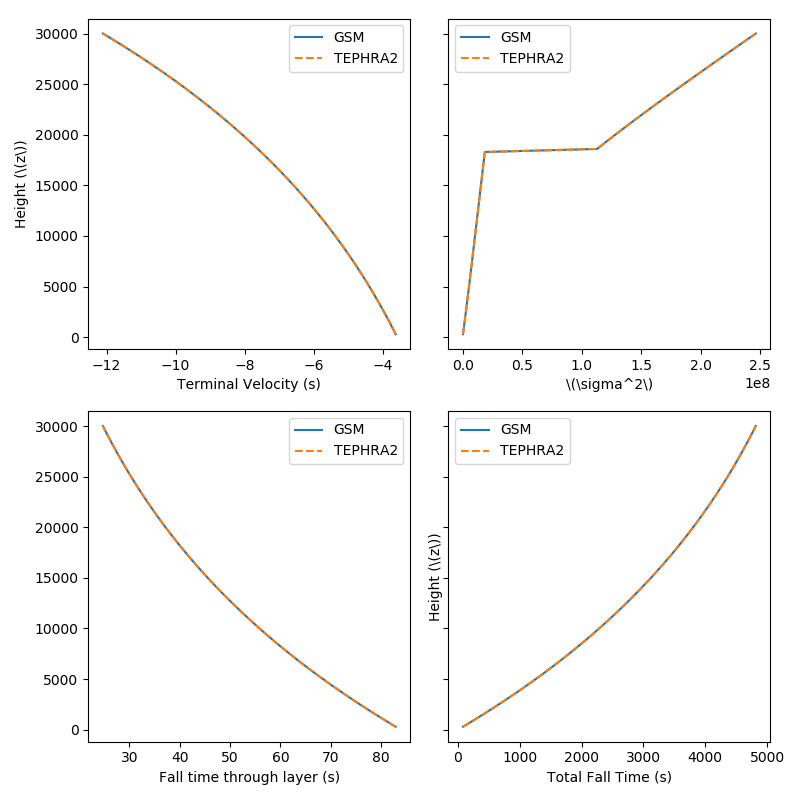

[ -3.61977  -3.66418  -3.70914  -3.75465  -3.80072  -3.84735  -3.89455
  -3.94234  -3.99071  -4.03967  -4.08924  -4.13941  -4.1902   -4.24161
  -4.29365  -4.34633  -4.39966  -4.45364  -4.50828  -4.5636   -4.61959
  -4.67627  -4.73364  -4.79172  -4.85051  -4.91002  -4.97027  -5.03125
  -5.09298  -5.15547  -5.21872  -5.28275  -5.34757  -5.41318  -5.4796
  -5.54683  -5.61488  -5.68377  -5.75351  -5.8241   -5.89556  -5.9679
  -6.04112  -6.11524  -6.19027  -6.26622  -6.3431   -6.42093  -6.49971
  -6.57946  -6.66018  -6.7419   -6.82462  -6.90835  -6.99311  -7.07891
  -7.16577  -7.25369  -7.34269  -7.43278  -7.52397  -7.61629  -7.70973
  -7.80433  -7.90008  -7.99701  -8.09513  -8.19445  -8.29499  -8.39676
  -8.49979  -8.60407  -8.70964  -8.8165   -8.92468  -9.03418  -9.14502
  -9.25722  -9.3708   -9.48578  -9.60216  -9.71998  -9.83923  -9.95995
 -10.0822  -10.2059  -10.3311  -10.4578  -10.5861  -10.716   -10.8475
 -10.9806  -11.1153  -11.2517  -11.3898  -11.5295  -11.671   -11.8142
 -11.9591 

In [8]:
part_data = pd.read_csv(in_tag + "_part_data.csv")
display(part_data)
fig, axs = plt.subplots(2,2, figsize=(
        8, 8), facecolor='w', edgecolor='k', sharey='row')
ax1, ax2, ax3, ax4 = axs.ravel()

ax1.plot(vv, input_table["Release Height (z)"], label="GSM")
ax1.plot(-part_data[" particle_term_vel"].values, input_table["Release Height (z)"], '--', label="TEPHRA2")
ax1.set_xlabel("Terminal Velocity (s)")
ax1.set_ylabel("Height (\(z\))")
ax1.legend()

print(-part_data[" particle_term_vel"].values)

ax2.plot(sig, input_table["Release Height (z)"], label="GSM")
ax2.plot(mass_data[mass_data["x"] == 0][" sigma"].values, input_table["Release Height (z)"], "--", label="TEPHRA2")
ax2.set_xlabel(r"\(\sigma^2\)")

ax2.legend()

ax3.plot(tft, input_table["Release Height (z)"], label="GSM")
ax3.plot(part_data[" particle_fall_time"].values, input_table["Release Height (z)"], '--', label="TEPHRA2")
ax3.set_xlabel("Fall time through layer (s)")

ax3.legend()

ax4.plot(np.cumsum(tft), input_table["Release Height (z)"], label="GSM")
ax4.plot(np.cumsum(part_data[" particle_fall_time"].values), input_table["Release Height (z)"], '--', label="TEPHRA2")
ax4.set_xlabel("Total Fall Time (s)")
ax4.set_ylabel("Height (\(z\))")
ax4.legend()
plt.tight_layout()
# plt.show()
plt.savefig(tag + "_internals.png", dpi=200, format='png')

In [9]:
t2_df["Mass"] = t2_df["MassArea"]*1000*1000
gsm_df["Mass"] = gsm_df["MassArea"]*1000*1000

print(tag + " GSM Total Mass: %e kg (%f per cent of input mass)"%
      (sum(t2_df["Mass"]), (sum(t2_df["Mass"])/ERUPTION_MASS)*100))
print(tag + " T2 Total Mass: %e kg (%f per cent of input mass)"%
      (sum(gsm_df["Mass"]), (sum(gsm_df["Mass"])/ERUPTION_MASS)*100))

pr69/mid_phi_med_wind GSM Total Mass: 1.000001e+10 kg (100.000130 per cent of input mass)
pr69/mid_phi_med_wind T2 Total Mass: 1.000001e+10 kg (100.000140 per cent of input mass)


### Filtering

In this simulation, a M/A threshold of 0.5 might not make a lot of sense, since we're still erupting too much mass.

In [10]:
threshold = 10e-5

t2_df = t2_df[t2_df["MassArea"] > threshold]
t2_df = t2_df[t2_df["Easting"] < 200000]
t2_df = t2_df[t2_df["Easting"] > -200000]
t2_df = t2_df[t2_df["Northing"] < 100000]
t2_df = t2_df[t2_df["Northing"] > -100000]


gsm_df = gsm_df[gsm_df["MassArea"] > threshold]
gsm_df = gsm_df[gsm_df["Easting"] < 200000]
gsm_df = gsm_df[gsm_df["Easting"] > -200000]
gsm_df = gsm_df[gsm_df["Northing"] < 100000]
gsm_df = gsm_df[gsm_df["Northing"] > -100000]
#display(gsm_df)
#display(t2_df)

piv_data = t2_df.pivot("Northing", "Easting", "MassArea")
gsm_piv = gsm_df.pivot("Northing", "Easting", "MassArea")

print(tag + " GSM Filtered Mass: %e kg (%f per cent of input mass)"%
      (sum(t2_df["Mass"]), (sum(t2_df["Mass"])/ERUPTION_MASS)*100))
print(tag + " T2 Filtered Mass: %e kg (%f per cent of input mass)"%
      (sum(gsm_df["Mass"]), (sum(gsm_df["Mass"])/ERUPTION_MASS)*100))


pr69/mid_phi_med_wind GSM Filtered Mass: 9.999947e+09 kg (99.999465 per cent of input mass)
pr69/mid_phi_med_wind T2 Filtered Mass: 9.999947e+09 kg (99.999472 per cent of input mass)


### Compare Deposits

Release heights are shown on the first plot. This is difficult to put on an axis, since it is non-linear with the landing points. 

<IPython.core.display.Javascript object>


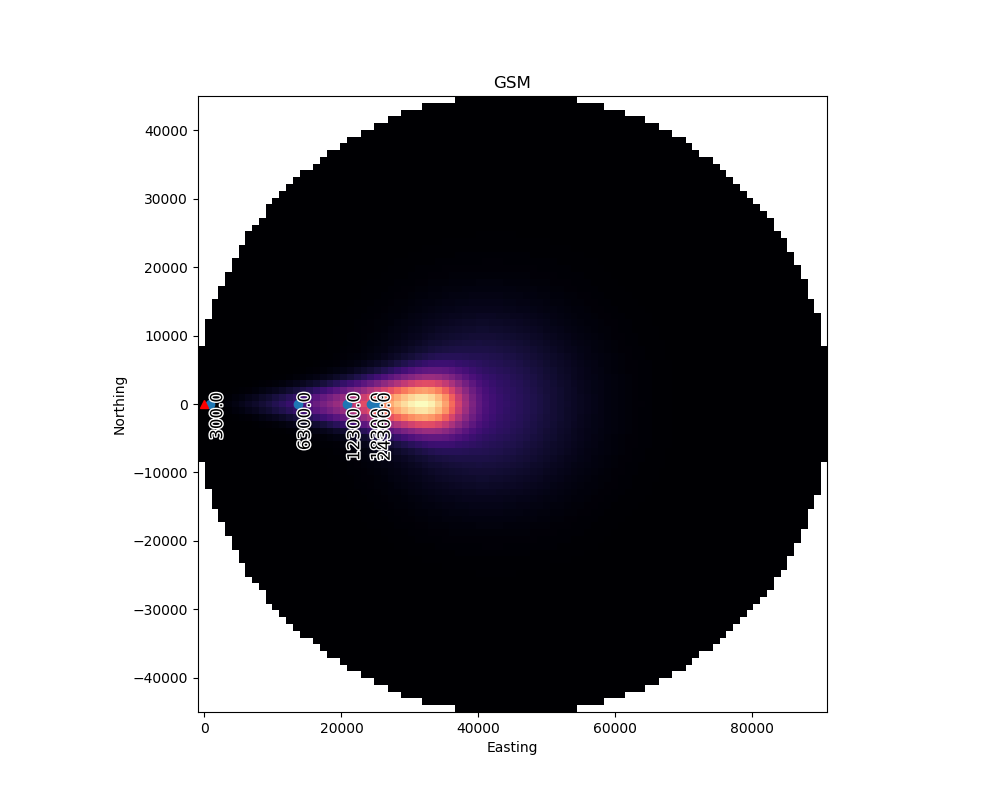

Text(0.5,1,'GSM')

In [11]:
fig, ax1 = plt.subplots(1,1, figsize=(
        10, 8), facecolor='w', edgecolor='k')
lower_lim = np.nanmin(gsm_piv.values)
upper_lim = np.nanmax(gsm_piv.values)


im1 = ax1.imshow(gsm_piv.values,
                 extent=[gsm_piv.columns.min(), gsm_piv.columns.max(),
                       gsm_piv.index.min(), gsm_piv.index.max()],
                 origin='lower',
                 cmap="magma", alpha=1,
                 vmin=lower_lim, 
                 vmax=upper_lim)
ax1.plot(0,0,"r^")

x_points = input_table["Landing Points (x_bar)"].values[::20]
y_points = [0]*len(x_points)

ax1.scatter(x_points, y_points)

dat_labels = input_table["Release Height (z)"].values[::20]

for i, txt in enumerate(dat_labels):
    ann = ax1.annotate(txt, (x_points[i], y_points[i]), rotation=90, fontsize=12)
    ann.set_path_effects([PathEffects.withStroke(linewidth=2, foreground='w')])

ax1.set_xlabel("Easting")
ax1.set_ylabel("Northing")
ax1.set_title("GSM")



<IPython.core.display.Javascript object>


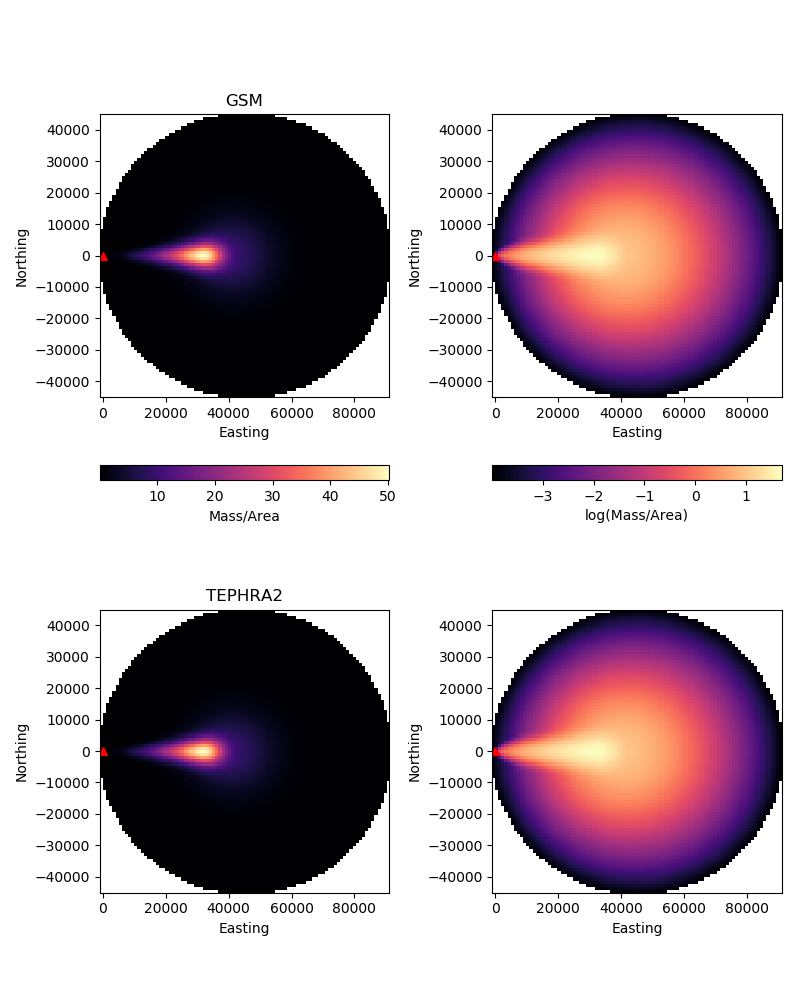

In [12]:


fig, axs = plt.subplots(2,2, figsize=(
        8, 10), facecolor='w', edgecolor='k')

# fig.subplots_adjust(bottom=0, top=1)


ax1, ax2, ax3, ax4 = axs.ravel()

im1 = ax1.imshow(gsm_piv.values,
                 extent=[gsm_piv.columns.min(), gsm_piv.columns.max(),
                       gsm_piv.index.min(), gsm_piv.index.max()],
                 origin='lower',
                 cmap="magma", alpha=1,
                 vmin=lower_lim, 
                 vmax=upper_lim, 
                aspect='equal')
ax1.plot(0,0,"r^")
ax1.set_xlabel("Easting")
ax1.set_ylabel("Northing")
ax1.set_title("GSM")

im2 = ax2.imshow(np.log10(gsm_piv.values),
                 extent=[gsm_piv.columns.min(), gsm_piv.columns.max(),
                       gsm_piv.index.min(), gsm_piv.index.max()],
                 origin='lower',
                 cmap="magma", alpha=1,
                 vmin=np.log10(lower_lim),
                 vmax=np.log10(upper_lim),
                aspect='equal')
ax2.plot(0,0,"r^")
ax2.set_xlabel("Easting")
ax2.set_ylabel("Northing")

im3 = ax3.imshow(piv_data.values,
                extent=[piv_data.columns.min(), piv_data.columns.max(),
                       piv_data.index.min(), piv_data.index.max()],
                origin='lower',
                cmap="magma", alpha=1,
                 vmin=lower_lim, 
                 vmax=upper_lim,
                aspect='equal')
ax3.plot(0,0,"r^")
ax3.set_xlabel("Easting")
ax3.set_ylabel("Northing")
ax3.set_title("TEPHRA2")

im4 = ax4.imshow(np.log10(piv_data.values),
                extent=[piv_data.columns.min(), piv_data.columns.max(),
                        piv_data.index.min(), piv_data.index.max()],
                origin='lower',
                cmap="magma", alpha=1,
                 vmin=np.log10(lower_lim), 
                 vmax=np.log10(upper_lim),
                aspect='equal')
ax4.plot(0,0,"r^")
ax4.set_xlabel("Easting")
ax4.set_ylabel("Northing")

ax1.set_ylim((min(ax1.get_ylim()[0], ax3.get_ylim()[0]), max(ax1.get_ylim()[1], ax3.get_ylim()[1])))
ax1.set_xlim((min(ax1.get_xlim()[0], ax3.get_xlim()[0]), max(ax1.get_xlim()[1], ax3.get_xlim()[1])))

ax2.set_ylim((min(ax2.get_ylim()[0], ax4.get_ylim()[0]), max(ax2.get_ylim()[1], ax4.get_ylim()[1])))
ax2.set_xlim((min(ax2.get_xlim()[0], ax4.get_xlim()[0]), max(ax2.get_xlim()[1], ax4.get_xlim()[1])))

ax3.set_ylim((min(ax1.get_ylim()[0], ax3.get_ylim()[0]), max(ax1.get_ylim()[1], ax3.get_ylim()[1])))
ax3.set_xlim((min(ax1.get_xlim()[0], ax3.get_xlim()[0]), max(ax1.get_xlim()[1], ax3.get_xlim()[1])))

ax4.set_ylim((min(ax2.get_ylim()[0], ax4.get_ylim()[0]), max(ax2.get_ylim()[1], ax4.get_ylim()[1])))
ax4.set_xlim((min(ax2.get_xlim()[0], ax4.get_xlim()[0]), max(ax2.get_xlim()[1], ax4.get_xlim()[1])))


fig.colorbar(im1, ax=ax1, label="Mass/Area", fraction=0.036, orientation='horizontal')
fig.colorbar(im2, ax=ax2, label="log(Mass/Area)", fraction=0.036, orientation='horizontal')
# fig.colorbar(im3, ax=ax3 ,label="Mass/Area", fraction=0.036, orientation='horizontal')
# fig.colorbar(im4, ax=ax4 ,label="log(Mass/Area)", fraction=0.036, orientation='horizontal')

plt.tight_layout()
# plt.show()
plt.savefig(tag + "_dists.png", dpi=200, format='png')

### Downwind Transection

93


<IPython.core.display.Javascript object>


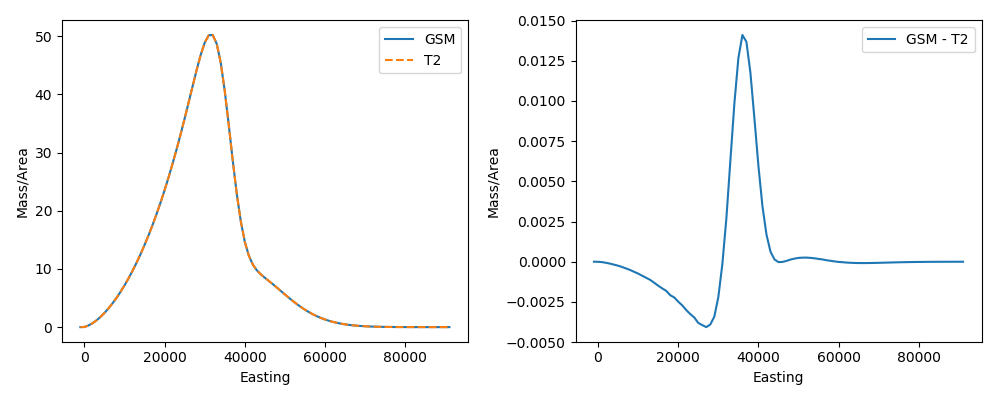

In [13]:
t2line = t2_df[t2_df["Northing"]==0]
#display(t2line)


gsm_line = gsm_df[gsm_df["Northing"]==0]
print(len(gsm_line))

fig, axs = plt.subplots(1,2, figsize=(
        10, 4), facecolor='w', edgecolor='k')

ax1, ax2 = axs.ravel()


ax1.plot(gsm_line["Easting"], gsm_line["MassArea"], label="GSM")
ax1.plot(t2line["Easting"], t2line["MassArea"], "--", label="T2")
ax1.legend()
ax1.set_xlabel("Easting")
ax1.set_ylabel("Mass/Area")
# plt.show()



ax2.plot(gsm_line["Easting"], gsm_line["MassArea"] - t2line["MassArea"], label="GSM - T2")
# plt.plot(t2line["Easting"], t2line["MassArea"], "--", label="T2")
ax2.legend()
ax2.set_xlabel("Easting")
ax2.set_ylabel("Mass/Area")
# plt.show()
plt.tight_layout()
plt.savefig(tag + "_transects.png", dpi=200, format='png')



### Sampling the deposits

n samples taken with alpha=.3

In [14]:
def sample(df, n, weight="MassArea", alpha=0.5):
    weights = df[weight].copy() # Get values to be used as weights
    weights = weights**(alpha) # Apply scaling factor as w^alpha
    probs = weights/np.sum(weights) # Normalise to sum up to one
    chosen = np.random.choice(df.index, n, replace=False, p=probs) # Randomly choose n points
    return df.loc[chosen]

array([127485, 145014, 126506, 124990, 123976, 125990, 125027, 106956,
       117016, 121483, 126515, 117964, 121477, 124484, 128514, 115459,
       129019, 137510, 119964, 128490, 135011, 119497, 125502, 133533,
       123489, 128007, 126965, 138514, 137043, 134011], dtype=int64)

<IPython.core.display.Javascript object>


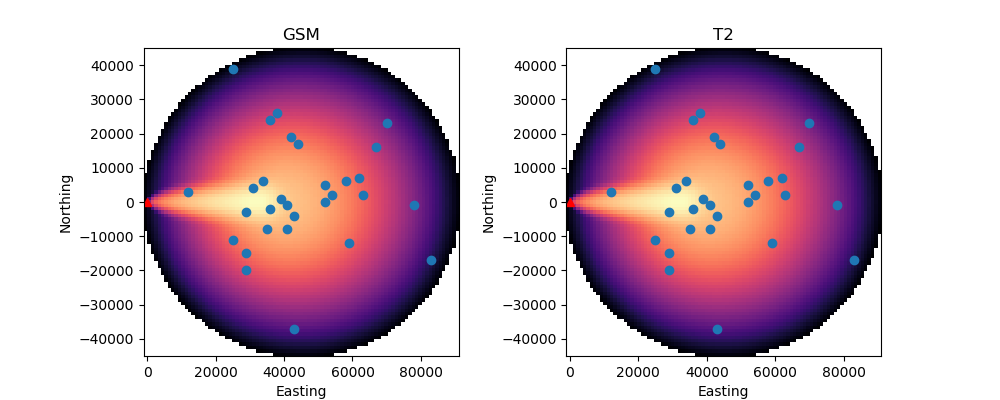

In [15]:
n=30

gsm_sample = sample(gsm_df, n, alpha=.3).copy()
display(gsm_sample.index.values)

t2_sample = t2_df.loc[gsm_sample.index]

fig, axs = plt.subplots(1,2, figsize=(
        10, 4), facecolor='w', edgecolor='k')

ax1, ax2 = axs.ravel()

im1 = ax1.imshow(np.log10(gsm_piv.values),
                 extent=[gsm_piv.columns.min(), gsm_piv.columns.max(),
                       gsm_piv.index.min(), gsm_piv.index.max()],
                 origin='lower',
                 cmap="magma", alpha=1,
                 vmin=np.log10(lower_lim),
                 vmax=np.log10(upper_lim))

ax1.scatter(gsm_sample["Easting"], gsm_sample["Northing"])
ax1.plot(0,0,"r^")
ax1.set_xlabel("Easting")
ax1.set_ylabel("Northing")
ax1.set_title("GSM")
im2 = ax2.imshow(np.log10(piv_data.values),
                 extent=[piv_data.columns.min(), piv_data.columns.max(),
                       piv_data.index.min(), piv_data.index.max()],
                 origin='lower',
                 cmap="magma", alpha=1,
                 vmin=np.log10(lower_lim),
                 vmax=np.log10(upper_lim))
ax2.set_title("T2")
ax2.scatter(t2_sample["Easting"], t2_sample["Northing"])
ax2.plot(0,0,"r^")
ax2.set_xlabel("Easting")
ax2.set_ylabel("Northing")


plt.show()
plt.savefig(tag + "_samps.png", dpi=200, format='png')

## Inverting Samples

c:\users\nmostert\envs\spew\lib\site-packages\ipykernel_launcher.py:146: FutureWarning: `rcond` parameter will change to the default of machine precision times ``max(M, N)`` where M and N are the input matrix dimensions.
To use the future default and silence this warning we advise to pass `rcond=None`, to keep using the old, explicitly pass `rcond=-1`.


<IPython.core.display.Javascript object>


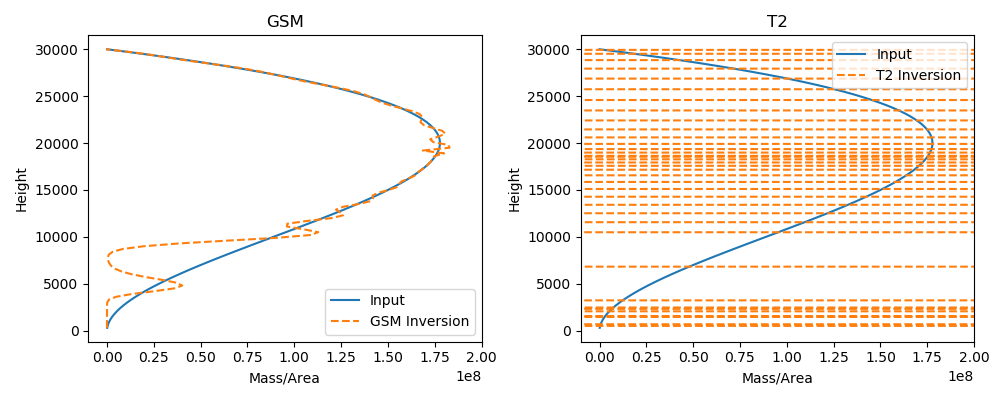

In [16]:


inversion_table_t2, _, _, _ = gaussian_stack_inversion(t2_sample, n, 
                                                          COL_STEPS, 0, 
                                                          PLUME_HEIGHT, 
                                                          ERUPTION_MASS, 
                                                          u, MAX_GRAINSIZE,
                                                          solver=None)

inversion_table_gsm, _, _, _ = gaussian_stack_inversion(gsm_sample, n, 
                                                          COL_STEPS, 0, 
                                                          PLUME_HEIGHT, 
                                                          ERUPTION_MASS, 
                                                          u, MAX_GRAINSIZE,
                                                          solver=None)

fig, axs = plt.subplots(1,2, figsize=(
        10, 4), facecolor='w', edgecolor='k')

ax1, ax2 = axs.ravel()

ax1.plot(input_table["Suspended Mass (q)"], input_table["Release Height (z)"], label="Input")
ax1.plot(inversion_table_gsm["Suspended Mass"], inversion_table_gsm["Height"], '--', label="GSM Inversion")
ax1.legend()
ax1.set_title("GSM")
ax1.set_ylabel("Height")
ax1.set_xlabel("Mass/Area")

ax2.plot(input_table["Suspended Mass (q)"], input_table["Release Height (z)"], label="Input")
ax2.plot(inversion_table_t2["Suspended Mass"], inversion_table_t2["Height"], '--', label="T2 Inversion")
ax2.legend()
ax2.set_title("T2")
ax2.set_ylabel("Height")
ax2.set_xlabel("Mass/Area")


ax2.set_xlim([-10000000,2e8])
ax1.set_xlim([-10000000,2e8])

plt.tight_layout()
# plt.show()
plt.savefig(tag + "_inversions.png", dpi=200, format='png')


<IPython.core.display.Javascript object>


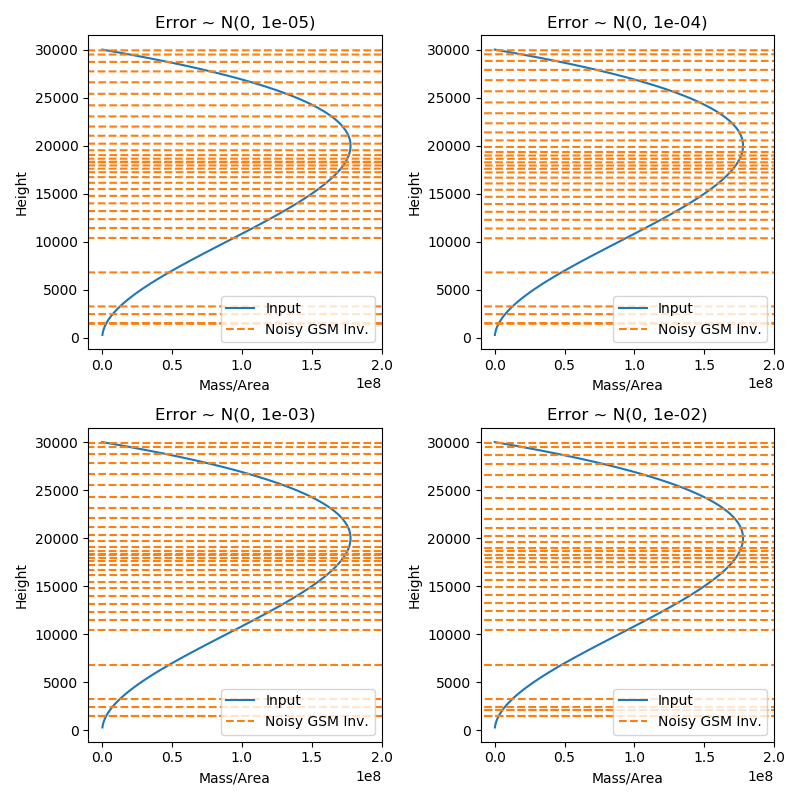

1e-05
0.0001
0.001
0.01


c:\users\nmostert\envs\spew\lib\site-packages\ipykernel_launcher.py:146: FutureWarning: `rcond` parameter will change to the default of machine precision times ``max(M, N)`` where M and N are the input matrix dimensions.
To use the future default and silence this warning we advise to pass `rcond=None`, to keep using the old, explicitly pass `rcond=-1`.


In [17]:
def add_noise(val,param):
    return val + np.random.normal(scale=param)


noises = [10e-6, 10e-5, 10e-4, 10e-3]

fig, axs = plt.subplots(2,2, figsize=(
        8, 8), facecolor='w', edgecolor='k')

axs = axs.ravel()


for i, noise in enumerate(noises):
    print(noise)
    gsm_noise = gsm_sample.copy()
    gsm_noise['MassArea'] = gsm_sample.apply(lambda x: add_noise(x['MassArea'],noise),axis=1)
    gsm_noise["noise"] = gsm_sample['MassArea'] - gsm_noise['MassArea']
#     axs[i].scatter(gsm_noise["Easting"], gsm_noise["noise"])
    inversion_table_gsm, _, _, _ = gaussian_stack_inversion(gsm_noise, n, 
                                                              COL_STEPS, 0, 
                                                              PLUME_HEIGHT, 
                                                              ERUPTION_MASS, 
                                                              u, MAX_GRAINSIZE)
    axs[i].plot(input_table["Suspended Mass (q)"], input_table["Release Height (z)"], label="Input")
    axs[i].plot(inversion_table_gsm["Suspended Mass"], inversion_table_gsm["Height"], '--', label="Noisy GSM Inv.")
    axs[i].legend()
    axs[i].set_title("Error ~ N(0, %.0e)"%noise)
    axs[i].set_ylabel("Height")
    axs[i].set_xlabel("Mass/Area")
    axs[i].set_xlim([-10000000,2e8])
plt.tight_layout()
plt.savefig(tag + "_noise.png", dpi=200, format='png')





### Testing the velocity profiles of TEPHRA2

Very dependendent on density, release height and and grain size. 

Constant velocity and constant density are not valid assumptions. 

<IPython.core.display.Javascript object>


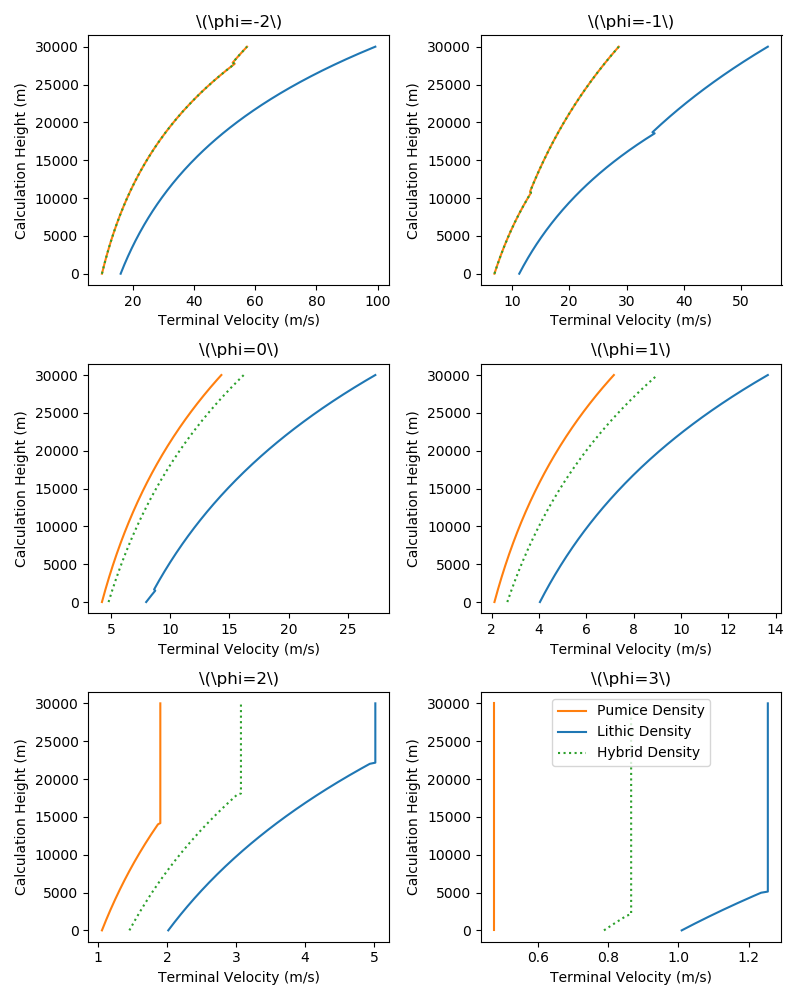

In [18]:
fig, axs = plt.subplots(3,2, figsize=(
        8, 10), facecolor='w', edgecolor='k')

axs = axs.ravel()

phis = [-2, -1, 0, 1, 2, 3]
for i, phi in enumerate(phis):
    
    if phi >= LITHIC_DIAMETER_THRESHOLD: 
        particle_density =  LITHIC_DENSITY
    elif phi <= PUMICE_DIAMETER_THRESHOLD:
        particle_density = PUMICE_DENSITY
    else:
        particle_density = LITHIC_DENSITY - (LITHIC_DENSITY - PUMICE_DENSITY) * (phi - LITHIC_DIAMETER_THRESHOLD)/(PUMICE_DIAMETER_THRESHOLD - LITHIC_DIAMETER_THRESHOLD)

    z = np.linspace(0, 30000, 200)
    d = phi2d(phi)/1000

    v_pum = [part_fall_time(zk, zk, d, PUMICE_DENSITY)[1] for zk in z]
    v_lit = [part_fall_time(zk, zk, d, LITHIC_DENSITY)[1] for zk in z]
    v_all = [part_fall_time(zk, zk, d, particle_density)[1] for zk in z]

    axs[i].plot(v_pum, z,  'C1-',label='Pumice Density')
    axs[i].plot(v_lit, z, 'C0-',label='Lithic Density')
    axs[i].plot(v_all, z, 'C2:',label='Hybrid Density')
    axs[i].set_title("\(\phi=%s\)"%str(phi))
    axs[i].set_xlabel("Terminal Velocity (m/s)")
    axs[i].set_ylabel("Calculation Height (m)")
plt.tight_layout()
plt.legend()
plt.show()
# plt.savefig("velocity.png", dpi=200, format='png')

### Residual Analysis

Currently on hold because it's not useful. 

<IPython.core.display.Javascript object>


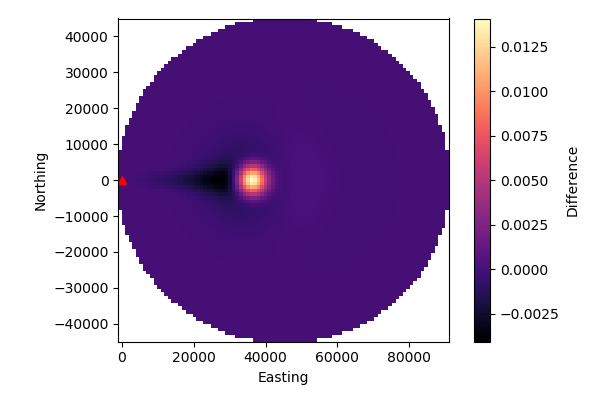

[[nan nan nan ... nan nan nan]
 [nan nan nan ... nan nan nan]
 [nan nan nan ... nan nan nan]
 ...
 [nan nan nan ... nan nan nan]
 [nan nan nan ... nan nan nan]
 [nan nan nan ... nan nan nan]]


In [19]:
fig, ax1 = plt.subplots(1,1, figsize=(
        6, 4), facecolor='w', edgecolor='k')

# ax1, ax2 = axs.ravel()


res = (gsm_piv.values - piv_data.values)
print(res)

im1 = ax1.imshow(res,
                extent=[piv_data.columns.min(), piv_data.columns.max(),
                        piv_data.index.min(), piv_data.index.max()],
                 origin='lower',
                 cmap="magma", alpha=1,)
#                  vmin=res.min(), 
#                  vmax=res.max())
ax1.plot(0,0,"r^")
ax1.set_xlabel("Easting")
ax1.set_ylabel("Northing")

fig.colorbar(im1, ax=ax1, label="Difference")


plt.tight_layout()
plt.show()

plt.savefig(tag + "_diff_map.png", dpi=200, format='png')